In [1]:
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations, product
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from untils.data_utils import generate_triplet_dataset, create_inventor_dictionary, generate_positive_dataset, generate_negative_dataset
from untils.base_models import MLP
from untils.dataset import Triplet_Dataset, Test_Dataset, Test_Dataset_Plus
from untils.train_utils import train_fn, eval_fn
from untils.test_utils import visualize_embeddings

## 1. Data Preprocessing
### 1.1 Load the Dataset (Disambiguated US Patents)

In [4]:
file_path = 'US_Patstat.tsv'
us_patstat_ = pd.read_csv(file_path, sep='\t')

In [5]:
us_patstat_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160245 entries, 0 to 160244
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   appln_id            160245 non-null  int64 
 1   appln_nr_epodoc     160245 non-null  object
 2   nb_inventors        160245 non-null  int64 
 3   granted             160245 non-null  bool  
 4   appln_filing_date   160245 non-null  object
 5   docdb_family_id     160245 non-null  int64 
 6   appln_title         160245 non-null  object
 7   appln_title_lg      160245 non-null  object
 8   appln_abstract      160245 non-null  object
 9   appln_abstract_lg   160245 non-null  object
 10  f0_                 160245 non-null  int64 
 11  f1_                 160240 non-null  object
 12  f2_                 143951 non-null  object
 13  f3_                 160245 non-null  object
 14  f4_                 108302 non-null  object
 15  f5_                 160245 non-null  object
 16  f6

In [6]:
# You can access only a small sample first
us_patstat = us_patstat_#.head(50000)
us_patstat.head(5)

,appln_id,appln_nr_epodoc,nb_inventors,granted,appln_filing_date,docdb_family_id,appln_title,appln_title_lg,appln_abstract,appln_abstract_lg,...,f4_,f5_,f6_,person_id,name_freeform,address_freeform,person_ctry_code,f7_,abstract_embedding,title_embedding
0,50187409,USD3661679,1,True,1970-09-08,22095217,ADHESIVE APPLICATOR FOR PLYWOOD PATCHING MACHINE,en,A conventional plywood patching machine is mod...,en,...,NaN,A,B27G 1/00&B27G 11/00,38741655,RAYMOND THOMAS LAW,NaN,,Y10T 156/1304&Y10T 156/1352&Y10T 156/1724&Y10T...,[-5.27917683e-01 7.01451823e-02 4.96898770e-...,[-7.15034425e-01 3.56434196e-01 -3.63022447e-...
1,57592923,US20080329133,3,True,2008-12-05,39667798,Memory circuit with decoupled read and write b...,en,"In a memory circuit, data from all cells along...",en,...,INDIVIDUAL,A,G11C 7/00,8303429,NaN,NaN,US,G11C 11/413&G11C 7/1045&G11C 7/22&G11C 1...,[-4.47309852e-01 -6.21297657e-01 -1.67965934e-...,[-1.18898368e+00 -3.33331138e-01 -2.78123587e-...
2,442230107,US201514662311,1,True,2015-03-19,38509096,System and method for enabling the fast extrac...,en,An improved system and method for deinterleavi...,en,...,INDIVIDUAL,A,G06F 13/28&H04N 5/232&H04N 5/225&G06K 15/00,6970729,NaN,NaN,FI,G06F 13/28&H04N 5/23293&H04N 5/2257,[-8.22747707e-01 -4.14333493e-01 5.23542762e-...,[-6.56469285e-01 -1.97614193e-01 -3.31190050e-...
3,50514439,US20030390567,3,False,2003-03-17,26719650,Novel human 7TM proteins and polynucleotides e...,en,The nucleotide and amino acid sequences of two...,en,...,NaN,A,C07K 14/705&C07H 21/04,33372782,ZAMBROWICZ BRIAN,NaN,US,C07H 21/04&C07K 14/705,[-2.79702425e-01 -2.80872881e-01 1.50826380e-...,[-7.34566450e-01 -3.11857700e-01 -3.87240708e-...
4,54155908,US20040921349,2,True,2004-08-19,34425839,Programmable asynchronous pipeline arrays,en,"High-performance, highly pipelined asynchronou...",en,...,NaN,A,H03K 19/177&H03K 19/173,10503639,NaN,NaN,US,H03K 19/17736,[-6.02215886e-01 -5.15534878e-01 1.48602933e-...,[-1.08743978e+00 -2.57100761e-01 -3.06084752e-...


### 1.2 Data Formatting
- Remove square brackets in title and abstract BERT embeddings
- Replace every occurrence of '9999-12-31' with '1999-12-31' in 'appln_filing_date' and convert to datetime
- Generate longitude and latitude by its country code

In [7]:
# 1. Remove square brackets and convert to list of floats
def process_string(x):
    # Remove all square brackets
    x = x.replace('[', ' ').replace(']', ' ')
    # Convert the modified string representation to a list of floats
    my_list = [float(elem) for elem in x.split()]
    return my_list

In [8]:
us_patstat['title_embedding'] = us_patstat['title_embedding'].apply(lambda x: process_string(x))
us_patstat['abstract_embedding'] = us_patstat['abstract_embedding'].apply(lambda x: process_string(x))

In [9]:
# 2. Replace every occurrence of '9999-12-31' with '1999-12-31' and convert to datetime
us_patstat['appln_filing_date'] = us_patstat['appln_filing_date'].replace('9999-12-31', '1999-12-31')
us_patstat['appln_filing_date'] = pd.to_datetime(us_patstat['appln_filing_date'])
us_patstat['filing_year'] = us_patstat['appln_filing_date'].dt.year # Extract year from 'appln_filing_date'

In [10]:
# 3. Generate longitude and latitude by its country code
# Load the longitude-latitude data
path = 'longitude-latitude.csv'
df_location = pd.read_csv(path)
df_location.drop_duplicates(subset=['ISO-ALPHA-2'], inplace=True)

# Make sure no duplicate country codes in the dataframe
df_location[df_location['ISO-ALPHA-2'] == 'US']

,Country,ISO-ALPHA-3,ISO-ALPHA-2,IOC,FIFA,Latitude,Longitude,ISO-Name,Historical,WikiData_ID,WikiData_Latitude,WikiData_Longitude,WikiData_Label,WikiData_Description
286,United States of America,USA,US,USA,USA,37.09024,-95.712891,1,0,Q30,39.83,-98.58,United States of America,sovereign state in North America


In [11]:
# Merge df_patstat with df_location based on country code
us_patstat = pd.merge(us_patstat, df_location[['ISO-ALPHA-2', 'Latitude', 'Longitude']], left_on='person_ctry_code', right_on='ISO-ALPHA-2', how='left')

# Drop the iso_alpha_2 column (optional)
us_patstat.drop(columns=['ISO-ALPHA-2'], inplace=True)

In [12]:
# Replace null values with 0 in 'Latitude' and 'Longitude' columns
us_patstat['Latitude'].fillna(0, inplace=True)
us_patstat['Longitude'].fillna(0, inplace=True)

### 1.3 Feature engineering
Features include abstract and title embeddings generated by BERT, latitude, longitude, number of inventors, whether it is granted, and the filing year.

In [13]:
def generate_encoded_features(df):
    # Extract text embeddings
    abstract_embeddings = np.stack(df['abstract_embedding'].values)
    title_embeddings = np.stack(df['title_embedding'].values)

    latitude_ = df['Latitude'].values.reshape(-1, 1)
    longitude_ = df['Longitude'].values.reshape(-1, 1)
    filing_year_ = df['filing_year'].values.reshape(-1, 1)
    nb_inventors_ = df['nb_inventors'].values.reshape(-1, 1)
    granted_ = df['granted'].astype(int).values.reshape(-1, 1)

    # Concatenate numerical features with text embeddings
    encoded_features = np.hstack((title_embeddings, abstract_embeddings, filing_year_, latitude_, longitude_, granted_))
    
    # Normalize the data
    scaler = StandardScaler()
    encoded_features = scaler.fit_transform(encoded_features)

    return encoded_features

In [14]:
# Generate encoded features
encoded_features = generate_encoded_features(us_patstat)

# Add encoded features to DataFrame
us_patstat['encoded_feature'] = encoded_features.tolist()

## 1.4. Dataset Preparation
- Testset: Patents whose person_id group has exact 48 data points
- Triplet Dataset: Anchor, Positive, Negative - for the model training under the triplet loss

In [15]:
# Group the DataFrame by 'person_id' and count the size of each group
group_sizes = us_patstat.groupby('person_id').size()

# Filter 'group_sizes' DataFrame to find group sizes between 50 and 61
person_ids_test = group_sizes[group_sizes.isin([48])].index.tolist()

# Filter us_patstat for test_patents and train_patstat
test_patents = us_patstat[us_patstat['person_id'].isin(person_ids_test)]
train_patstat = us_patstat[~us_patstat['person_id'].isin(person_ids_test)]

# Print the sizes of test_patents and train_patstat
print("Size of test_patents:", len(test_patents))
print("Size of train_patstat:", len(train_patstat))

Size of test_patents: 432
Size of train_patstat: 159813


In [16]:
# Generate positive pairs and negative pairs in testset
test_dict = create_inventor_dictionary(test_patents)
test_positive_df = generate_positive_dataset(test_dict)
test_negative_df = generate_negative_dataset(test_dict)
combined_data = pd.concat([test_positive_df, test_negative_df], ignore_index=True)

# Shuffle the combined_data DataFrame
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

# Check the distribution of labels
label_distribution = combined_data['Label'].value_counts()
label_distribution

Label
0    165888
1     10152
Name: count, dtype: int64

In [17]:
# Generate triplet dataset
inventor_dict = create_inventor_dictionary(train_patstat)
triplet_dataset = generate_triplet_dataset(inventor_dict)
triplet_dataset.head(5)

,Anchor,Positive,Negative
0,"{54307827: [0.7164788360596089, 1.031949470966...","{48350553: [-0.3283670386928386, 2.11997024799...","{476233682: [-0.4474583514297819, -0.590411658..."
1,"{54307827: [0.7164788360596089, 1.031949470966...","{54090935: [-1.0271425376375964, -1.0547549575...","{51748118: [-2.270052808794201, 0.040481371377..."
2,"{54307827: [0.7164788360596089, 1.031949470966...","{49389085: [-0.12603252963875017, -1.265594519...","{48399086: [-0.01956505096250128, 2.8290856126..."
3,"{54307827: [0.7164788360596089, 1.031949470966...","{46832944: [-1.0429930728750916, -1.7555382949...","{516082058: [0.9156871868174954, 0.08492543787..."
4,"{48350553: [-0.3283670386928386, 2.11997024799...","{54090935: [-1.0271425376375964, -1.0547549575...","{51736915: [-0.5859461357483462, -0.1571187215..."


## 2. Siamese Networks with Triplet Loss
### 2.1 Model Training

In [18]:
train_patents, valid_patents = train_test_split(triplet_dataset, test_size=0.1, random_state=88)

In [19]:
trainset = Triplet_Dataset(train_patents)
validset = Triplet_Dataset(valid_patents)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 732144
Size of validset: 81350


In [20]:
batch_size = 64
input_size = trainset[0][0].shape[0]
hidden_sizes = [2048, 1024, 512] 
output_size = 20

model = MLP(input_size, hidden_sizes, output_size)

# Create DataLoader 
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

# Define the criterion (Triplet Margin Loss)
criterion = nn.TripletMarginLoss(margin=0.2, p=2) 

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=1540, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=20, bias=True)
  )
)

In [21]:
best_valid_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(model, trainloader, optimizer, criterion, device)
    valid_loss = eval_fn(model, validloader, criterion, device)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 1272/1272 [00:35<00:00, 35.37it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1 train_loss: 0.14417691878108244 valid_loss: 0.06869480445975168


100%|██████████| 1272/1272 [00:41<00:00, 30.75it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2 train_loss: 0.05977006964523905 valid_loss: 0.03757522917395083


100%|██████████| 1272/1272 [00:40<00:00, 31.13it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3 train_loss: 0.027380785015224434 valid_loss: 0.031170336138266697


100%|██████████| 1272/1272 [00:41<00:00, 30.48it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 4 train_loss: 0.013193980356701974 valid_loss: 0.029854114102961134


100%|██████████| 1272/1272 [00:40<00:00, 31.19it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 5 train_loss: 0.007490404797868536 valid_loss: 0.028657561815314512


100%|██████████| 1272/1272 [00:36<00:00, 35.20it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 6 train_loss: 0.004821022094729669 valid_loss: 0.027082286795796006


100%|██████████| 1272/1272 [00:35<00:00, 36.13it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 7 train_loss: 0.003442639556629042 valid_loss: 0.026779271964988315


100%|██████████| 1272/1272 [00:54<00:00, 23.14it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 8 train_loss: 0.002620050308483464 valid_loss: 0.026069975044774537


100%|██████████| 1272/1272 [00:37<00:00, 33.58it/s]


EPOCHS: 9 train_loss: 0.0019356818631180673 valid_loss: 0.02615995530907428


100%|██████████| 1272/1272 [00:35<00:00, 35.72it/s]

EPOCHS: 10 train_loss: 0.001602137774974759 valid_loss: 0.027651584783895528


In [22]:
torch.save(model.state_dict(), 'models/best_model.pt')

In [23]:
model.load_state_dict(torch.load('models/best_model.pt'))

<All keys matched successfully>

### 2.2 Output Visualization

In [24]:
testset = Test_Dataset(test_patents)
testloader = DataLoader(testset, batch_size = 64)

In [25]:
model.eval()

# Create an empty list to store the embeddings
embeddings = []

with torch.no_grad():
    for patent in tqdm(testloader):
        
        patent = patent.to(device)

        patent_embs = model(patent)
        embeddings.append(patent_embs)

embeddings_combined = torch.cat(embeddings, dim=0)
inventor_ids = test_patents['person_id'].values

100%|██████████| 7/7 [00:00<00:00, 48.29it/s]


Average Silhouette Coefficient: 0.05843942


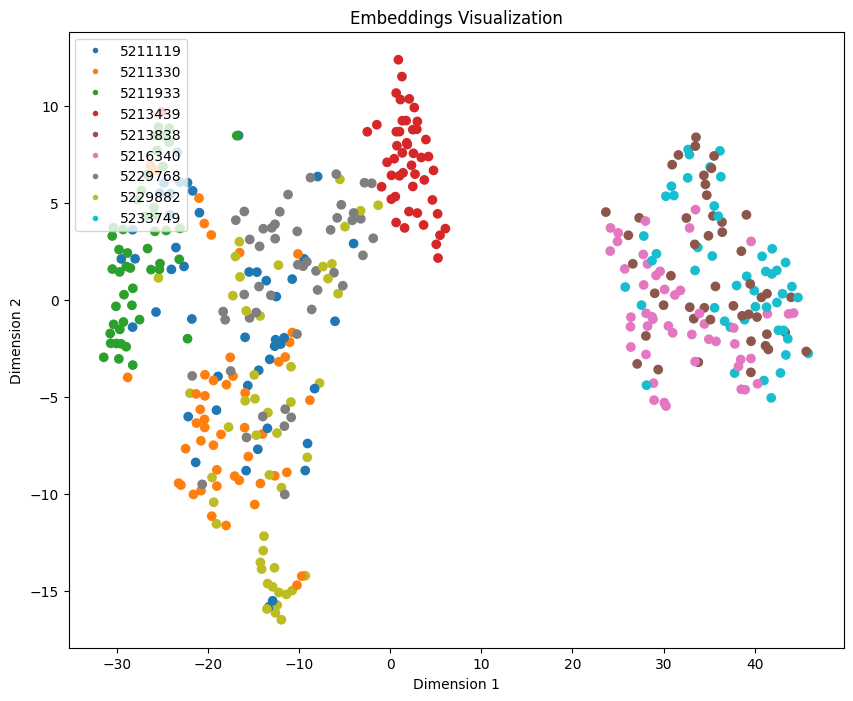

In [26]:
visualize_embeddings(embeddings_combined, inventor_ids)

### 2.3 Model Evaluation

In [41]:
# class Test_Dataset_Plus(Dataset):
#     def __init__(self, df):
#         self.df = df

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         patent = self.data.iloc[idx]
#         P1 = next(iter(patent.Patent1.values()))
#         P2 = next(iter(patent.Patent2.values()))
#         label = patent.Label  # No need to access .values here
#         return np.array(P1, dtype=np.float32), np.array(P2, dtype=np.float32), label

In [45]:
from torch.utils.data import DataLoader, Dataset

class Test_Dataset_Plus(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patent = self.df.iloc[idx]  # Corrected typo: change self.data to self.df
        P1 = next(iter(patent.Patent1.values()))
        P2 = next(iter(patent.Patent2.values()))
        label = patent.Label  # No need to access .values here
        return np.array(P1, dtype=np.float32), np.array(P2, dtype=np.float32), label

In [46]:
# Create a DataLoader for the test dataset
testset_ = Test_Dataset_Plus(combined_data)
testloader_ = torch.utils.data.DataLoader(testset_, batch_size=64, shuffle=False)

In [ ]:
embeddings_P1 = []
embeddings_P2 = []
labels = []

with torch.no_grad():
    for P1, P2, label in tqdm(testloader_):
        P1, P2 = P1.to(device), P2.to(device)
        patent_embs_P1 = model(P1)
        patent_embs_P2 = model(P2)
        embeddings_P1.append(patent_embs_P1) 
        embeddings_P2.append(patent_embs_P2)
        labels.append(label)
        
embeddings_combined_P1 = torch.cat(embeddings_P1, dim=0)
embeddings_combined_P2 = torch.cat(embeddings_P2, dim=0)
ground_truth = torch.cat(labels, dim=0)

 51%|█████▏    | 1411/2751 [00:32<00:29, 45.05it/s]

In [36]:
from torch.nn.functional import cosine_similarity
cosine_sim = cosine_similarity(embeddings_combined_P1, embeddings_combined_P2)

# Define a threshold for classification (adjust as needed)
threshold = 0.95
# Apply thresholding to get binary predictions
binary_predictions = (cosine_sim >= threshold).float()

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(ground_truth, binary_predictions)
precision = precision_score(ground_truth, binary_predictions)
recall = recall_score(ground_truth, binary_predictions)
f1 = f1_score(ground_truth, binary_predictions)

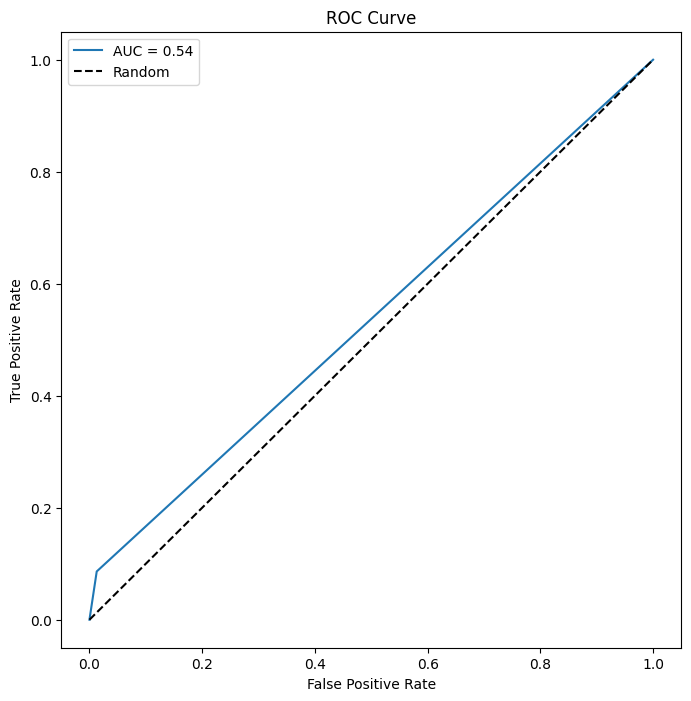

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(ground_truth, binary_predictions)

# Calculate AUC score
auc_score = roc_auc_score(ground_truth, binary_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [40]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9352
Precision: 0.2904
Recall: 0.0862
F1 Score: 0.1329
